In [1]:
import requests
import pandas as pd
import os
import matplotlib.pyplot as plt

### Wczytanie danych i analiza

In [2]:
relative_path = "nypd-motor-vehicle-collisions.csv"

if not os.path.exists(relative_path):

    url = "https://data.cityofnewyork.us/api/views/h9gi-nx95/rows.csv?accessType=DOWNLOAD"
    response = requests.get(url)
    
    if response.status_code == 200:
        with open(relative_path, "wb") as f:
            f.write(response.content)
        print("Plik CSV został pomyślnie pobrany.")
    else:
        print("Wystąpił problem podczas pobierania pliku CSV.")
else:
    print(f"Plik {relative_path} już istnieje.")

Plik nypd-motor-vehicle-collisions.csv już istnieje.


### Czyszczenie danych 

In [3]:
df = pd.read_csv(relative_path)

exclude_columns = [
    'CRASH TIME', 'ZIP CODE','LATITUDE','LONGITUDE', 'LOCATION',
    'ON STREET NAME', 'CROSS STREET NAME', 'OFF STREET NAME', 
    'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF PEDESTRIANS KILLED',
    'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED',
    'NUMBER OF MOTORIST INJURED', 'NUMBER OF MOTORIST KILLED',
]

duplikaty = df.duplicated(subset=["COLLISION_ID"])

if duplikaty.any():
    print("Znaleziono duplikaty dla kolumny 'COLLISION_ID'.")
    print(df[duplikaty])
else:
    print("Nie znaleziono duplikatów dla kolumny 'COLLISION_ID'.")

df = df.drop(columns=exclude_columns)
df = df.dropna(subset=['BOROUGH'])

df['NUMBER OF PERSONS INJURED'] = df['NUMBER OF PERSONS INJURED'].fillna(0).astype(int)
df['NUMBER OF PERSONS KILLED'] = df['NUMBER OF PERSONS KILLED'].fillna(0).astype(int)

df.to_csv("nypd-motor-vehicle-collisions-updated.csv", index=False)
print("Zaktualizowany plik CSV został zapisany.")
print(df.head(5))

/var/folders/ns/jk_b9prs22d33gc8xp4v3xph0000gn/T/ipykernel_11123/1677951621.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(relative_path)


Nie znaleziono duplikatów dla kolumny 'COLLISION_ID'.
Zaktualizowany plik CSV został zapisany.
   CRASH DATE    BOROUGH  NUMBER OF PERSONS INJURED  NUMBER OF PERSONS KILLED  \
3  09/11/2021   BROOKLYN                          0                         0   
4  12/14/2021   BROOKLYN                          0                         0   
7  12/14/2021      BRONX                          2                         0   
8  12/14/2021   BROOKLYN                          0                         0   
9  12/14/2021  MANHATTAN                          0                         0   

  CONTRIBUTING FACTOR VEHICLE 1 CONTRIBUTING FACTOR VEHICLE 2  \
3                   Unspecified                           NaN   
4                           NaN                           NaN   
7                   Unspecified                   Unspecified   
8           Driver Inexperience                   Unspecified   
9           Passing Too Closely                   Unspecified   

  CONTRIBUTING FACTOR VEHIC

In [4]:
contributing_factors = pd.concat([
    df['CONTRIBUTING FACTOR VEHICLE 1'],
    df['CONTRIBUTING FACTOR VEHICLE 2'],
    df['CONTRIBUTING FACTOR VEHICLE 3'],
    df['CONTRIBUTING FACTOR VEHICLE 4'],
    df['CONTRIBUTING FACTOR VEHICLE 5']
])

unique_factors = contributing_factors.unique()
print("Unique contributing factors:", unique_factors)

unique_factor_counts = contributing_factors.value_counts()

print("Ilość unikalnych czynników wypadków samochodowych:", len(unique_factor_counts))

Unique contributing factors: ['Unspecified' nan 'Driver Inexperience' 'Passing Too Closely'
 'Turning Improperly' 'Reaction to Uninvolved Vehicle' 'Steering Failure'
 'Following Too Closely' 'Passing or Lane Usage Improper'
 'Driver Inattention/Distraction' 'Oversized Vehicle'
 'Unsafe Lane Changing' 'Alcohol Involvement' 'View Obstructed/Limited'
 'Traffic Control Disregarded' 'Failure to Yield Right-of-Way'
 'Aggressive Driving/Road Rage' 'Unsafe Speed' 'Pavement Slippery'
 'Illnes' 'Lost Consciousness' 'Other Vehicular' 'Brakes Defective'
 'Backing Unsafely' 'Passenger Distraction' 'Fell Asleep'
 'Obstruction/Debris' 'Tinted Windows'
 'Pedestrian/Bicyclist/Other Pedestrian Error/Confusion' 'Animals Action'
 'Drugs (illegal)' 'Outside Car Distraction' 'Tire Failure/Inadequate'
 'Pavement Defective' 'Fatigued/Drowsy' 'Accelerator Defective'
 'Physical Disability' 'Glare' 'Driverless/Runaway Vehicle'
 'Eating or Drinking' 'Failure to Keep Right' 'Cell Phone (hands-free)'
 'Lane Marking

In [5]:
def calculate_casualties(df, factor_columns):
    casualties_list = []
    for factor_column in factor_columns:
        df_factor = df[['BOROUGH', 'NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED',
                        factor_column]].dropna(subset=[factor_column])
        df_factor['TOTAL_CASUALTIES'] = df_factor[['NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED',
                                                   ]].sum(axis=1)
        casualties_list.append(df_factor.groupby(['BOROUGH', factor_column])['TOTAL_CASUALTIES'].sum().reset_index())
    
    all_casualties = pd.concat(casualties_list)
    total_casualties = all_casualties.groupby(['BOROUGH', all_casualties.columns[1]])['TOTAL_CASUALTIES'].sum().reset_index()
    return total_casualties

factor_columns = ['CONTRIBUTING FACTOR VEHICLE 1', 'CONTRIBUTING FACTOR VEHICLE 2',
                  'CONTRIBUTING FACTOR VEHICLE 3', 'CONTRIBUTING FACTOR VEHICLE 4',
                  'CONTRIBUTING FACTOR VEHICLE 5']

total_casualties = calculate_casualties(df, factor_columns)

most_dangerous_factors = total_casualties.loc[total_casualties.groupby('BOROUGH')['TOTAL_CASUALTIES'].idxmax()]

### Najniebezpieczniejsze czynniki

In [6]:
print(most_dangerous_factors)

           BOROUGH CONTRIBUTING FACTOR VEHICLE 1  TOTAL_CASUALTIES
55           BRONX                   Unspecified             23221
116       BROOKLYN                   Unspecified             56730
177      MANHATTAN                   Unspecified             18782
238         QUEENS                   Unspecified             32195
298  STATEN ISLAND                   Unspecified              5159


In [7]:
df_filtered = df[
    (df['CONTRIBUTING FACTOR VEHICLE 1'] != 'Unspecified') &
    (df['CONTRIBUTING FACTOR VEHICLE 2'] != 'Unspecified') &
    (df['CONTRIBUTING FACTOR VEHICLE 3'] != 'Unspecified') &
    (df['CONTRIBUTING FACTOR VEHICLE 4'] != 'Unspecified') &
    (df['CONTRIBUTING FACTOR VEHICLE 5'] != 'Unspecified')
]

total_casualties = calculate_casualties(df_filtered, factor_columns)

#Wskazanie najniebezpieczniejszych czynników dla każdej z dzielnic
most_dangerous_factors = total_casualties.loc[total_casualties.groupby('BOROUGH')['TOTAL_CASUALTIES'].idxmax()].reset_index(drop=True)

#Rename dla lepszej czytelności outputu
most_dangerous_factors = most_dangerous_factors.rename(columns={most_dangerous_factors.columns[1]: 'CONTRIBUTING FACTOR'})


### Najniebezpieczniejsze czynniki z podzialem na dzielnice(z wylaczeniem 'Unspecified')

In [8]:
print("Najniebezpieczniejsze czynniki z podzialem na dzielnice(z wylaczeniem 'Unspecified'):")
print(most_dangerous_factors)

Najniebezpieczniejsze czynniki z podzialem na dzielnice(z wylaczeniem 'Unspecified'):
         BOROUGH             CONTRIBUTING FACTOR  TOTAL_CASUALTIES
0          BRONX  Driver Inattention/Distraction              6200
1       BROOKLYN  Driver Inattention/Distraction             11971
2      MANHATTAN  Driver Inattention/Distraction              9042
3         QUEENS  Driver Inattention/Distraction             11291
4  STATEN ISLAND  Driver Inattention/Distraction              1404


### Wniosek:

In [9]:
print("Unikalne wartosci zostaly wcześniej przejrzane, jedyny factor powiazany z szybka jazda to 'Unsafe Speed'") 

Unikalne wartosci zostaly wcześniej przejrzane, jedyny factor powiazany z szybka jazda to 'Unsafe Speed'


In [10]:
speed_df = df[(df['CONTRIBUTING FACTOR VEHICLE 1'] == 'Unsafe Speed') |
              (df['CONTRIBUTING FACTOR VEHICLE 2'] == 'Unsafe Speed') |
              (df['CONTRIBUTING FACTOR VEHICLE 3'] == 'Unsafe Speed') |
              (df['CONTRIBUTING FACTOR VEHICLE 4'] == 'Unsafe Speed') |
              (df['CONTRIBUTING FACTOR VEHICLE 5'] == 'Unsafe Speed')]

speed_casualties = speed_df.groupby('BOROUGH')[['NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED']].sum().reset_index()

speed_casualties['TOTAL_CASUALTIES'] = speed_casualties['NUMBER OF PERSONS INJURED'] + speed_casualties['NUMBER OF PERSONS KILLED']

speed_casualties['NUMBER OF PERSONS INJURED'] = speed_casualties['NUMBER OF PERSONS INJURED'].astype(int)
speed_casualties['NUMBER OF PERSONS KILLED'] = speed_casualties['NUMBER OF PERSONS KILLED'].astype(int)
speed_casualties['TOTAL_CASUALTIES'] = speed_casualties['TOTAL_CASUALTIES'].astype(int)

### Wniosek: 

In [11]:
print("Poszkodowani przez szybką jazdę:")
print(speed_casualties.to_string(index=False))

Poszkodowani przez szybką jazdę:
      BOROUGH  NUMBER OF PERSONS INJURED  NUMBER OF PERSONS KILLED  TOTAL_CASUALTIES
        BRONX                       2971                        27              2998
     BROOKLYN                       4064                        50              4114
    MANHATTAN                       1297                        13              1310
       QUEENS                       3467                        51              3518
STATEN ISLAND                        558                        11               569


In [12]:
def get_top_factors(df, group_col, factor_cols, top_n=3, exclude_unspecified=False):
    factor_counts = df.groupby(group_col)[factor_cols].apply(lambda x: x.stack().value_counts()).reset_index()
    factor_counts.columns = [group_col, 'CONTRIBUTING FACTOR', 'COUNT']
    if exclude_unspecified:
        factor_counts = factor_counts[factor_counts['CONTRIBUTING FACTOR'] != 'Unspecified']
    top_factors = factor_counts.groupby(group_col).apply(lambda x: x.nlargest(top_n, 'COUNT')).reset_index(drop=True)
    return top_factors

top_factors_boroughs = get_top_factors(df, 'BOROUGH', factor_columns, top_n=3)
top_factors_boroughs_no_unspecified = get_top_factors(df, 'BOROUGH', factor_columns, top_n=3, exclude_unspecified=True)

top_factors_city = df[factor_columns].stack().value_counts().head(3).reset_index()
top_factors_city.columns = ['CONTRIBUTING FACTOR', 'COUNT']
top_factors_city_no_unspecified = df[factor_columns].stack().value_counts().reset_index()
top_factors_city_no_unspecified.columns = ['CONTRIBUTING FACTOR', 'COUNT']
top_factors_city_no_unspecified = top_factors_city_no_unspecified[top_factors_city_no_unspecified['CONTRIBUTING FACTOR'] != 'Unspecified'].head(3)



/var/folders/ns/jk_b9prs22d33gc8xp4v3xph0000gn/T/ipykernel_11123/3202029139.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_factors = factor_counts.groupby(group_col).apply(lambda x: x.nlargest(top_n, 'COUNT')).reset_index(drop=True)
/var/folders/ns/jk_b9prs22d33gc8xp4v3xph0000gn/T/ipykernel_11123/3202029139.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_factors = factor_counts.groupby(grou

### Wniosek:

In [13]:
print("Top 3 najczęstsze czynniki wypadków dla każdej dzielnicy (z 'Unspecified'):")
print(top_factors_boroughs)

print("\nTop 3 najczęstsze czynniki wypadków dla każdej dzielnicy (bez 'Unspecified'):")
print(top_factors_boroughs_no_unspecified)

print("\nTop 3 najczęstsze czynniki wypadków dla całego miasta (z 'Unspecified'):")
print(top_factors_city)

print("\nTop 3 najczęstsze czynniki wypadków dla całego miasta (bez 'Unspecified'):")
print(top_factors_city_no_unspecified)

Top 3 najczęstsze czynniki wypadków dla każdej dzielnicy (z 'Unspecified'):
          BOROUGH             CONTRIBUTING FACTOR   COUNT
0           BRONX                     Unspecified  251226
1           BRONX  Driver Inattention/Distraction   43219
2           BRONX                 Other Vehicular   14411
3        BROOKLYN                     Unspecified  570538
4        BROOKLYN  Driver Inattention/Distraction   94759
5        BROOKLYN   Failure to Yield Right-of-Way   33063
6       MANHATTAN                     Unspecified  325036
7       MANHATTAN  Driver Inattention/Distraction   89474
8       MANHATTAN                 Other Vehicular   30639
9          QUEENS                     Unspecified  455013
10         QUEENS  Driver Inattention/Distraction   99572
11         QUEENS   Failure to Yield Right-of-Way   37497
12  STATEN ISLAND                     Unspecified   73677
13  STATEN ISLAND  Driver Inattention/Distraction   13917
14  STATEN ISLAND   Failure to Yield Right-of-Way    4

In [14]:
vehicle_columns = ['VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2', 'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5']

df[vehicle_columns] = df[vehicle_columns].apply(lambda x: x.str.strip().str.upper())

for col in vehicle_columns:
    df = df[df[col] != 'UNKNOWN']

vehicle_counts_cleaned = df[vehicle_columns].stack().value_counts().reset_index()
vehicle_counts_cleaned.columns = ['VEHICLE TYPE', 'COUNT']

vehicle_counts_cleaned.index = vehicle_counts_cleaned.index + 1

In [15]:
non_null_values = df['BOROUGH'].count()
print("Liczba wartości nie-null dla kolumny 'BOROUGH':", non_null_values)

Liczba wartości nie-null dla kolumny 'BOROUGH': 1358620


### Wyświetlenie ilości wypadków dla każdej z dzielnic, za okres 2012-2024

In [16]:
borough_counts = df['BOROUGH'].value_counts()
print("Ilość wypadków dla każdej z dzielnic w latach 2012-2024:")
print(borough_counts)

Ilość wypadków dla każdej z dzielnic w latach 2012-2024:
BOROUGH
BROOKLYN         430581
QUEENS           364724
MANHATTAN        307142
BRONX            199338
STATEN ISLAND     56835
Name: count, dtype: int64


In [17]:
df['CRASH DATE'] = pd.to_datetime(df['CRASH DATE'])

df['YEAR'] = df['CRASH DATE'].dt.year

borough_year_counts = df.groupby(['BOROUGH', 'YEAR']).size().reset_index(name='COUNT')
borough_year_table = borough_year_counts.pivot(index='YEAR', columns='BOROUGH', values='COUNT')

borough_year_table = borough_year_table.fillna(0)

### Tabela dotyczaca statystyki wypadkow z podzialem na dzielnice

In [18]:
print("Statystyka ilości wypadków dla każdego roku i każdej z dzielnic:")
print(borough_year_table)

Statystyka ilości wypadków dla każdego roku i każdej z dzielnic:
BOROUGH  BRONX  BROOKLYN  MANHATTAN  QUEENS  STATEN ISLAND
YEAR                                                      
2012      7954     19816      18628   16270           4276
2013     16343     39965      37757   34048           7241
2014     16123     40467      37480   35206           5675
2015     16989     42553      38099   36286           5497
2016     20700     45634      35180   39901           6514
2017     21396     44915      31773   38627           6241
2018     23059     47313      31412   41278           6171
2019     22437     44479      26592   39865           3650
2020     14301     25462      10846   20661           2388
2021     13381     25162      11409   19552           2665
2022     12279     23348      11973   18419           2718
2023     10497     22870      11808   17779           2722
2024      3879      8597       4185    6832           1077


In [19]:
df['CRASH DATE'] = pd.to_datetime(df['CRASH DATE'], format='%d/%m/%Y')

def map_to_quarter(date):
    month = date.month
    if month in [1, 2, 3]:
        return 'Q1'
    elif month in [4, 5, 6]:
        return 'Q2'
    elif month in [7, 8, 9]:
        return 'Q3'
    else:
        return 'Q4'

df['QUARTER'] = df['CRASH DATE'].apply(map_to_quarter)

borough_year_quarter_counts = df.groupby(['BOROUGH', 'YEAR', 'QUARTER']).size().reset_index(name='COUNT')
borough_year_quarter_table = borough_year_quarter_counts.pivot_table(index=['YEAR', 'QUARTER'], columns='BOROUGH', values='COUNT', fill_value=0)

borough_year_quarter_table = borough_year_quarter_table.astype(int)


### Wnioski

In [20]:
print("Most dangerous factors for each borough:")
print(most_dangerous_factors)
print ("Driver Inattention/Distraction jest najniebezpieczniejszym czynnikiem przyczyniającym się do wypadków w całym Nowym Jorku - gdyż występował w każdej z dzielnic")
print ("Nieuwaga kierowców miała największy impakt w Brookylnie - łącznie poszkodowanych bylo z tego powodu aż 11945 osób. Najmniej zaś, w Staten Island - 1403 osoby")


Most dangerous factors for each borough:
         BOROUGH             CONTRIBUTING FACTOR  TOTAL_CASUALTIES
0          BRONX  Driver Inattention/Distraction              6200
1       BROOKLYN  Driver Inattention/Distraction             11971
2      MANHATTAN  Driver Inattention/Distraction              9042
3         QUEENS  Driver Inattention/Distraction             11291
4  STATEN ISLAND  Driver Inattention/Distraction              1404
Driver Inattention/Distraction jest najniebezpieczniejszym czynnikiem przyczyniającym się do wypadków w całym Nowym Jorku - gdyż występował w każdej z dzielnic
Nieuwaga kierowców miała największy impakt w Brookylnie - łącznie poszkodowanych bylo z tego powodu aż 11945 osób. Najmniej zaś, w Staten Island - 1403 osoby


In [21]:
print("Poszkodowani przez szybką jazdę:")
print(speed_casualties.to_string(index=False))
print ("Mozna zaobserwować, że najwyszą liczbą ofiar z powodu szybkiej jazdy charakteryzował sie Brooklyn - w którym łączna ilość bezpośrednio poszkodowanych wyniosła 4101 osób. Najniższa zaś miała miejsce w Staten Island - 569 osób poszkodowanych")
print ("Dodatkowo można zauwayżyć, iż w Queens w wyniku szybkiej jazdy najwięcej osób stracilo życie - 51 osób")

Poszkodowani przez szybką jazdę:
      BOROUGH  NUMBER OF PERSONS INJURED  NUMBER OF PERSONS KILLED  TOTAL_CASUALTIES
        BRONX                       2971                        27              2998
     BROOKLYN                       4064                        50              4114
    MANHATTAN                       1297                        13              1310
       QUEENS                       3467                        51              3518
STATEN ISLAND                        558                        11               569
Mozna zaobserwować, że najwyszą liczbą ofiar z powodu szybkiej jazdy charakteryzował sie Brooklyn - w którym łączna ilość bezpośrednio poszkodowanych wyniosła 4101 osób. Najniższa zaś miała miejsce w Staten Island - 569 osób poszkodowanych
Dodatkowo można zauwayżyć, iż w Queens w wyniku szybkiej jazdy najwięcej osób stracilo życie - 51 osób


In [22]:
print("\nTop 3 najczęstsze czynniki wypadków dla każdej dzielnicy:")
print(top_factors_boroughs_no_unspecified)
print("\nTop 3 najczęstsze czynniki wypadków dla całego miasta:")
print(top_factors_city_no_unspecified)
print("Popierając poprzednie wyniki - Driver Inattention/Distraction był najczęstszą przyczyną wypadków w NY oraz każdej z dzielnic - współprzyczyniał się on do wystąpienia wypadku drogowego w aż 340642 razy")
print("Kolejnym najczęściej występującym czynnikiem w całym mieście był 'Failure to Yield Right-of-Way' - nieudzielenie pierwszeństwa przejazdu współprzyczyniało się aż 104098 razy")



Top 3 najczęstsze czynniki wypadków dla każdej dzielnicy:
          BOROUGH             CONTRIBUTING FACTOR  COUNT
0           BRONX  Driver Inattention/Distraction  43219
1           BRONX                 Other Vehicular  14411
2           BRONX   Failure to Yield Right-of-Way  11437
3        BROOKLYN  Driver Inattention/Distraction  94759
4        BROOKLYN   Failure to Yield Right-of-Way  33063
5        BROOKLYN                Backing Unsafely  19958
6       MANHATTAN  Driver Inattention/Distraction  89474
7       MANHATTAN                 Other Vehicular  30639
8       MANHATTAN   Failure to Yield Right-of-Way  17947
9          QUEENS  Driver Inattention/Distraction  99572
10         QUEENS   Failure to Yield Right-of-Way  37497
11         QUEENS                Backing Unsafely  20729
12  STATEN ISLAND  Driver Inattention/Distraction  13917
13  STATEN ISLAND   Failure to Yield Right-of-Way   4233
14  STATEN ISLAND                Backing Unsafely   2905

Top 3 najczęstsze czynniki w

In [23]:
print("Najczęściej uczestniczące pojazdy w wypadkach po czyszczeniu danych:")
print(vehicle_counts_cleaned.head(20))
print("Najczęściej występującymi pojazdami w wypadkach drogowych w NY były samochody typu Sedan oraz SUV")

Najczęściej uczestniczące pojazdy w wypadkach po czyszczeniu danych:
                           VEHICLE TYPE   COUNT
1                                 SEDAN  663825
2   STATION WAGON/SPORT UTILITY VEHICLE  522877
3                     PASSENGER VEHICLE  518326
4         SPORT UTILITY / STATION WAGON  228426
5                                  TAXI  111590
6                         PICK-UP TRUCK   59400
7                                   VAN   50973
8                                   BUS   50001
9                            4 DR SEDAN   48518
10                            BOX TRUCK   35967
11                                 BIKE   34644
12                                OTHER   34347
13               SMALL COM VEH(4 TIRES)   20651
14       LARGE COM VEH(6 OR MORE TIRES)   18946
15                              BICYCLE   16179
16                           MOTORCYCLE   15486
17                       LIVERY VEHICLE   14959
18                 TRACTOR TRUCK DIESEL   10043
19                 

In [24]:
print("Statystyka ilości wypadków dla każdego kwartału w każdej z dzielnic:")
print(borough_year_quarter_table)

Statystyka ilości wypadków dla każdego kwartału w każdej z dzielnic:
BOROUGH       BRONX  BROOKLYN  MANHATTAN  QUEENS  STATEN ISLAND
YEAR QUARTER                                                   
2012 Q3        4031      9880       9721    8117           2096
     Q4        3923      9936       8907    8153           2180
2013 Q1        3884      9026       8274    7668           1994
     Q2        4354     10723       9955    8717           2257
     Q3        4128      9948       9708    8567           1367
     Q4        3977     10268       9820    9096           1623
2014 Q1        3929      9372       8321    8283           1471
     Q2        4122     10409      10003    8926           1446
     Q3        4109     10350       9561    8903           1370
     Q4        3963     10336       9595    9094           1388
2015 Q1        3908      9702       8007    8405           1278
     Q2        4284     10735      10003    9053           1387
     Q3        4365     10974      

### Wykres kolowy w ujeciu procentowym

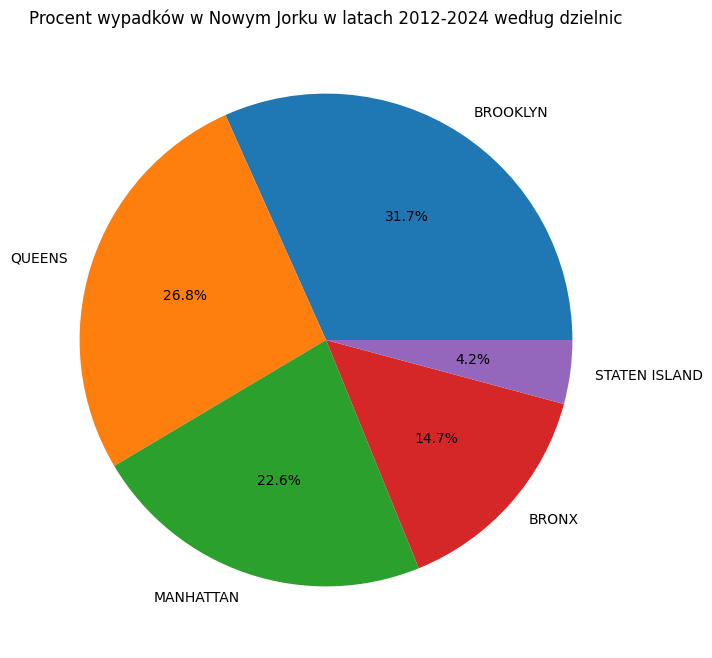

In [25]:
plt.figure(figsize=(8, 8))
plt.pie(borough_counts, labels=borough_counts.index, autopct="%1.1f%%")
plt.title("Procent wypadków w Nowym Jorku w latach 2012-2024 według dzielnic")
plt.show()

### Wykres obrazujacy ilosc wypadkow rocznie z podzialem na kwartaly i dzielnice

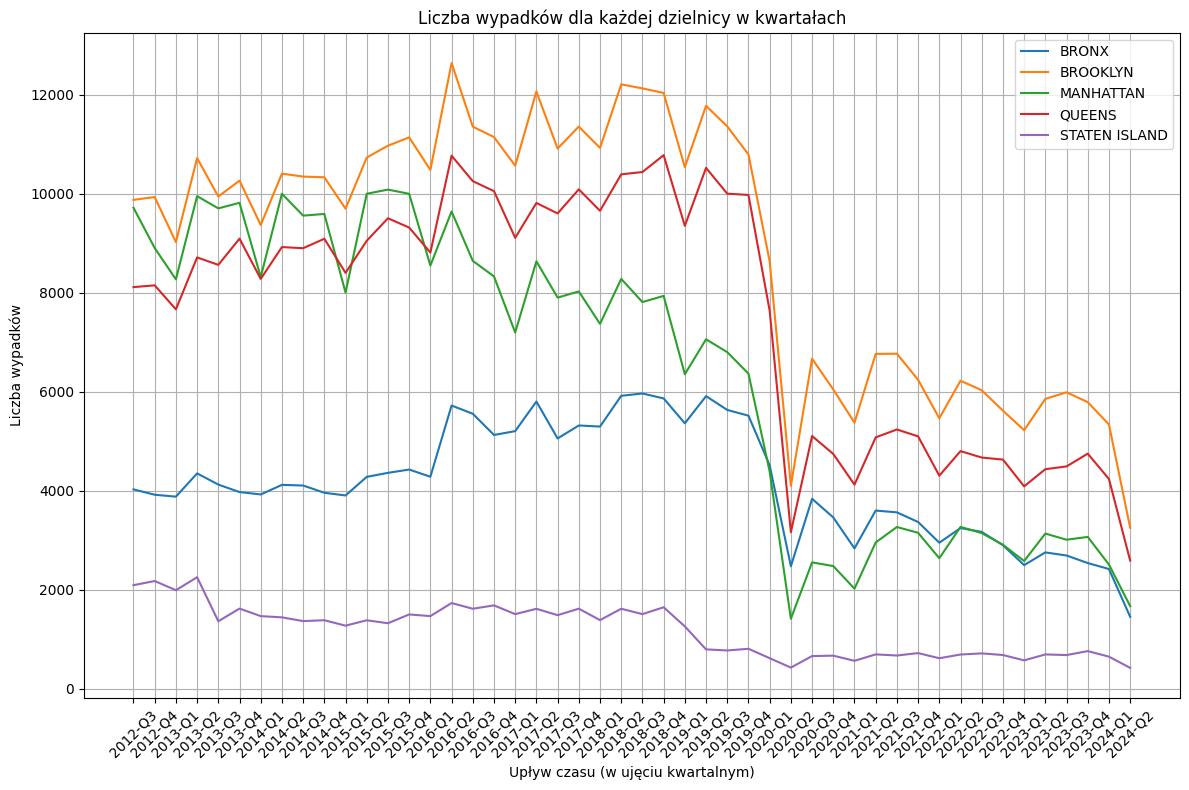

Na podstawie poniżej przedstawionej tabeli oraz wykresów można zaobserwować następująco:
1. W Brooklynie doszlo do największej ilości wypadków ogólem - aż 31.7%, a najmniej w Staten Island - jedynie 4.2%.
2. Znaczny spadek liczby wypadków w 2020 roku - co można hipotetycznie przypisać pandemii COVID-19, która miała wówczas znaczny impakt na przemieszczanie się ludzi. Spadek ten nie jest jednak zauważalny w Staten Island.
3. Liczba wypadków w pierwszym kwartale (Q1) i czwartym kwartale (Q4) jest zwykle niższa niż w drugim (Q2) i trzecim kwartale (Q3), co może być związane z warunkami pogodowymi oraz zmianami w natężeniu ruchu w ciągu roku.
4.Dla każdej z dzielnic można wskazać kwartały, w których doszło do największej ilości wypadków:
Bronx - Wypadki w Bronxie osiągnęły szczyt w 2016 roku (Q2) z liczbą 5725 wypadków.
Brooklyn - Najwyższa liczba wypadków została zarejestrowana w Q2 2016 roku (12643 wypadków)
Manhattan - Wypadki w Manhattanie były najwyższe w 2018 roku (Q1), z liczbą 9030

In [27]:
plt.figure(figsize=(12, 8))

for borough in borough_year_quarter_table.columns:
    plt.plot(borough_year_quarter_table.index.get_level_values('YEAR').astype(str) + '-' + borough_year_quarter_table.index.get_level_values('QUARTER'), borough_year_quarter_table[borough], label=borough)

plt.xlabel('Upływ czasu (w ujęciu kwartalnym)')
plt.ylabel('Liczba wypadków')
plt.title('Liczba wypadków dla każdej dzielnicy w kwartałach')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



print("Na podstawie poniżej przedstawionej tabeli oraz wykresów można zaobserwować następująco:")
print("1. W Brooklynie doszlo do największej ilości wypadków ogólem - aż 31.7%, a najmniej w Staten Island - jedynie 4.2%.")
print("2. Znaczny spadek liczby wypadków w 2020 roku - co można hipotetycznie przypisać pandemii COVID-19, która miała wówczas znaczny impakt na przemieszczanie się ludzi. Spadek ten nie jest jednak zauważalny w Staten Island.")
print ("3. Liczba wypadków w pierwszym kwartale (Q1) i czwartym kwartale (Q4) jest zwykle niższa niż w drugim (Q2) i trzecim kwartale (Q3), co może być związane z warunkami pogodowymi oraz zmianami w natężeniu ruchu w ciągu roku.")


print("4.Dla każdej z dzielnic można wskazać kwartały, w których doszło do największej ilości wypadków:")
print("Bronx - Wypadki w Bronxie osiągnęły szczyt w 2016 roku (Q2) z liczbą 5725 wypadków.")
print("Brooklyn - Najwyższa liczba wypadków została zarejestrowana w Q2 2016 roku (12643 wypadków)")
print("Manhattan - Wypadki w Manhattanie były najwyższe w 2018 roku (Q1), z liczbą 9030 wypadków.")
print("Queens - Najwyższa liczba wypadków miała miejsce w Q2 2018 roku (10395 wypadków)")
print("Staten Island - Najwyższa liczba wypadków miała miejsce w Q2 2016 roku (1735 wypadków)")